<a href="https://colab.research.google.com/github/yashkeswani29-cpu/Aluminum-Prices-Procurement/blob/main/Aluminum_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install yfinance arch statsmodels

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
from arch import arch_model
import statsmodels.api as sm

print("Libraries ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 17.3 MB/s eta 0:00:00
Libraries ready.


In [ ]:
ticker = "ALI=F"
period = "10y"

df = yf.download(ticker, period=period, interval="1d").dropna()
df = df.loc[~df.index.duplicated(keep='last')]
assert len(df) > 0, "No data downloaded. Check ticker or internet connection."


df['ret'] = np.log(df['Close']).diff()
df['rv']  = df['ret']**2
df = df.dropna()

print(df.head())

[*********************100%***********************]  1 of 1 completed

Price        Close    High     Low    Open Volume       ret            rv
Ticker       ALI=F   ALI=F   ALI=F   ALI=F  ALI=F                        
Date                                                                     
2015-08-26  1611.5  1611.5  1611.5  1611.5      0 -0.014477  2.095946e-04
2015-08-27  1652.5  1652.5  1652.5  1652.5      0  0.025124  6.312089e-04
2015-08-28  1688.5  1688.5  1688.5  1688.5      2  0.021551  4.644572e-04
2015-08-31  1688.5  1688.5  1688.5  1688.5      0  0.000000  0.000000e+00
2015-09-01  1690.0  1690.0  1690.0  1690.0      0  0.000888  7.884873e-07


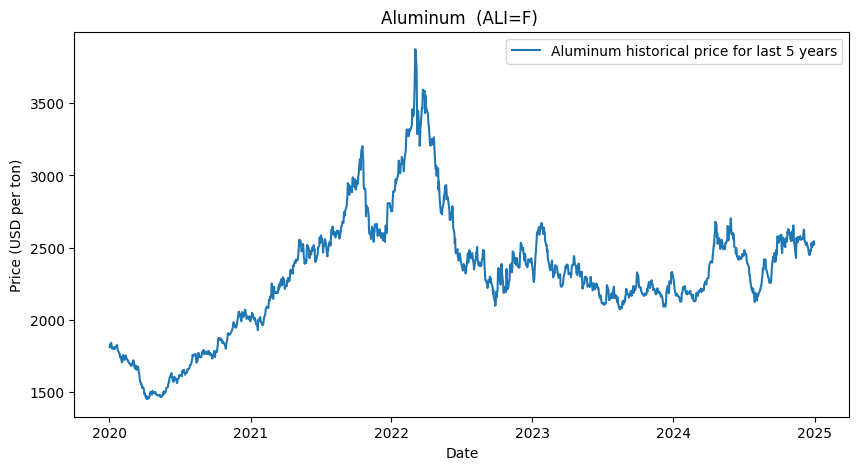

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(aluminum.index, aluminum['Close'], label='Aluminum historical price for last 5 years')
plt.xlabel("Date")
plt.ylabel("Price (USD per ton)")
plt.title("Aluminum  (ALI=F) ")
plt.legend()
plt.savefig("aluminum_price.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
split = int(len(df) * 0.9)
train, test = df.iloc[:split].copy(), df.iloc[split:].copy()

len(train), len(test), df.index[0], df.index[-1]

(2229, 248, Timestamp('2015-08-26 00:00:00'), Timestamp('2025-08-25 00:00:00'))

In [ ]:
history = train['ret'].copy()
garch_forecasts = []

for idx, r in test['ret'].items():
    am = arch_model(history, vol='GARCH', p=1, q=1, dist='t', mean='Zero')
    res = am.fit(disp='off')
    fcast = res.forecast(horizon=1).variance.iloc[-1, 0]
    garch_forecasts.append((idx, float(fcast)))

    history = pd.concat([history, pd.Series([r], index=[idx])])

garch_var = pd.Series({i: v for i, v in garch_forecasts}).sort_index()
print("GARCH forecasts (last 5):")
print(garch_var.tail())

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

GARCH forecasts (last 5):
2025-08-19    0.000124
2025-08-20    0.000131
2025-08-21    0.000152
2025-08-22    0.000136
2025-08-25    0.000125
dtype: float64


In [ ]:

 import torch
 import torch.nn as nn
 from sklearn.preprocessing import StandardScaler


 seq = 21
 series = df['rv'].values.reshape(-1,1)
 scaler = StandardScaler()
 z = scaler.fit_transform(series)

 Xs, ys = [], []
 for i in range(seq, len(z)-1):
     Xs.append(z[i-seq:i, :])
     ys.append(z[i+1, 0])
 Xs, ys = np.array(Xs), np.array(ys)

 split = int(0.9 * len(Xs))
 Xtr, Xte = Xs[:split], Xs[split:]
 ytr, yte = ys[:split], ys[split:]

 Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
 ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1,1)
 Xte_t = torch.tensor(Xte, dtype=torch.float32)
 yte_t = torch.tensor(yte, dtype=torch.float32).view(-1,1)

 class LSTM(nn.Module):
     def __init__(self, input_size=1, hidden=16):
         super().__init__()
         self.lstm = nn.LSTM(input_size, hidden, batch_first=True)
         self.fc = nn.Linear(hidden, 1)
     def forward(self, x):
         out, _ = self.lstm(x)
         out = out[:, -1, :]
         return self.fc(out)

 model = LSTM()
 opt = torch.optim.Adam(model.parameters(), lr=1e-3)
 loss_fn = nn.MSELoss()

 for epoch in range(100):
     model.train()
     opt.zero_grad()
     pred = model(Xtr_t)
     loss = loss_fn(pred, ytr_t)
     loss.backward()
     opt.step()
     if (epoch+1) % 5 == 0:
         print("Epoch", epoch+1, "Loss", float(loss.item()))

 model.eval()
 with torch.no_grad():
     yhat = model(Xte_t).numpy().ravel()

 yhat_unscaled = scaler.inverse_transform(yhat.reshape(-1,1)).ravel()
 yte_unscaled  = scaler.inverse_transform(yte.reshape(-1,1)).ravel()


 lstm_var = pd.Series(yhat_unscaled, index=df.index[-len(yte_unscaled):])
 print(lstm_var.tail())


Epoch 5 Loss 1.1027202606201172
Epoch 10 Loss 1.1020996570587158
Epoch 15 Loss 1.1015119552612305
Epoch 20 Loss 1.1007786989212036
Epoch 25 Loss 1.1001453399658203
Epoch 30 Loss 1.0994311571121216
Epoch 35 Loss 1.0986615419387817
Epoch 40 Loss 1.0978517532348633
Epoch 45 Loss 1.0969676971435547
Epoch 50 Loss 1.0960419178009033
Epoch 55 Loss 1.0951086282730103
Epoch 60 Loss 1.0942741632461548
Epoch 65 Loss 1.0937598943710327
Epoch 70 Loss 1.093729019165039
Epoch 75 Loss 1.0937418937683105
Epoch 80 Loss 1.0935778617858887
Epoch 85 Loss 1.0934970378875732
Epoch 90 Loss 1.0934745073318481
Epoch 95 Loss 1.0934364795684814
Epoch 100 Loss 1.0933860540390015
Date
2025-08-19    0.000127
2025-08-20    0.000124
2025-08-21    0.000131
2025-08-22    0.000139
2025-08-25    0.000139
dtype: float32


In [ ]:
test_index = garch_var.index.intersection(lstm_var.index)
test_rv = (df['ret']**2).reindex(test_index)

def mse(yhat, y): return ((yhat - y)**2).mean()
def mae(yhat, y): return (yhat.sub(y).abs()).mean()
def qlike(yhat, y): return (np.log(y) + (yhat / y)).mean()

print("GARCH  -> MSE:", mse(garch_var.reindex(test_index), test_rv),
      " MAE:", mae(garch_var.reindex(test_index), test_rv),
      " QLIKE:", qlike(garch_var.reindex(test_index), test_rv))

print("LSTM   -> MSE:", mse(lstm_var.reindex(test_index), test_rv),
      " MAE:", mae(lstm_var.reindex(test_index), test_rv),
      " QLIKE:", qlike(lstm_var.reindex(test_index), test_rv))

GARCH  -> MSE: 1.3245607026400494e-07  MAE: 0.00020546259702103765  QLIKE: 120.58525576063208
LSTM   -> MSE: 1.1005423605052603e-07  MAE: 0.00020085149817988593  QLIKE: 139.10670080852358


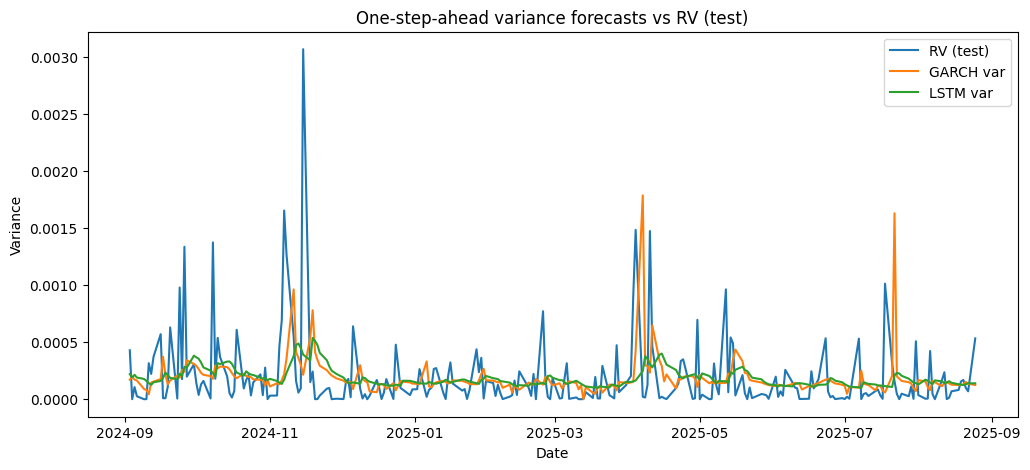

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_rv.index, test_rv.values, label="RV (test)")
plt.plot(garch_var.reindex(test_rv.index).index, garch_var.reindex(test_rv.index).values, label="GARCH var")
plt.plot(lstm_var.reindex(test_rv.index).index, lstm_var.reindex(test_rv.index).values, label="LSTM var")
plt.title("One-step-ahead variance forecasts vs RV (test)")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.savefig("aluminum_price1.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
px = df['Close'].copy()
dS = px.pct_change().dropna()
dF = dS.copy()

window = 60
hr = dS.rolling(window).cov(dF) / dF.rolling(window).var()
hr = hr.dropna().clip(lower=0)

common_idx = garch_var.index.intersection(hr.index)
hr_adj = hr.reindex(common_idx).iloc[:, 0]
gvar = garch_var.reindex(common_idx)

expected_tons_next_month = 1000.0
contract_size_tons = 25.0

thr = gvar.quantile(0.9)
trim = (gvar > thr).map({True: 0.85, False: 1.0})

hedge_tons = (hr_adj * trim) * expected_tons_next_month
hedge_lots = (hedge_tons / contract_size_tons).round()

out = pd.DataFrame({
    'price': px.reindex(common_idx).iloc[:, 0],
    'mv_hedge_ratio': hr_adj,
    'garch_var': gvar,
    'trim_factor': trim,
    'hedge_tons': hedge_tons,
    'hedge_lots_25t': hedge_lots
}).dropna()

print(out.tail(10))

              price  mv_hedge_ratio  garch_var  trim_factor  hedge_tons  \
2025-08-12  2507.75             1.0   0.000141          1.0      1000.0   
2025-08-13  2510.50             1.0   0.000152          1.0      1000.0   
2025-08-14  2501.50             1.0   0.000138          1.0      1000.0   
2025-08-15  2480.75             1.0   0.000127          1.0      1000.0   
2025-08-18  2458.50             1.0   0.000125          1.0      1000.0   
2025-08-19  2428.00             1.0   0.000124          1.0      1000.0   
2025-08-20  2459.75             1.0   0.000131          1.0      1000.0   
2025-08-21  2484.50             1.0   0.000152          1.0      1000.0   
2025-08-22  2505.25             1.0   0.000136          1.0      1000.0   
2025-08-25  2563.75             1.0   0.000125          1.0      1000.0   

            hedge_lots_25t  
2025-08-12            40.0  
2025-08-13            40.0  
2025-08-14            40.0  
2025-08-15            40.0  
2025-08-18            40.0  


            hedge_lots_garch  hedge_lots_lstm
2025-08-12              40.0             40.0
2025-08-13              40.0             40.0
2025-08-14              40.0             40.0
2025-08-15              40.0             40.0
2025-08-18              40.0             40.0
2025-08-19              40.0             40.0
2025-08-20              40.0             40.0
2025-08-21              40.0             40.0
2025-08-22              40.0             40.0
2025-08-25              40.0             40.0


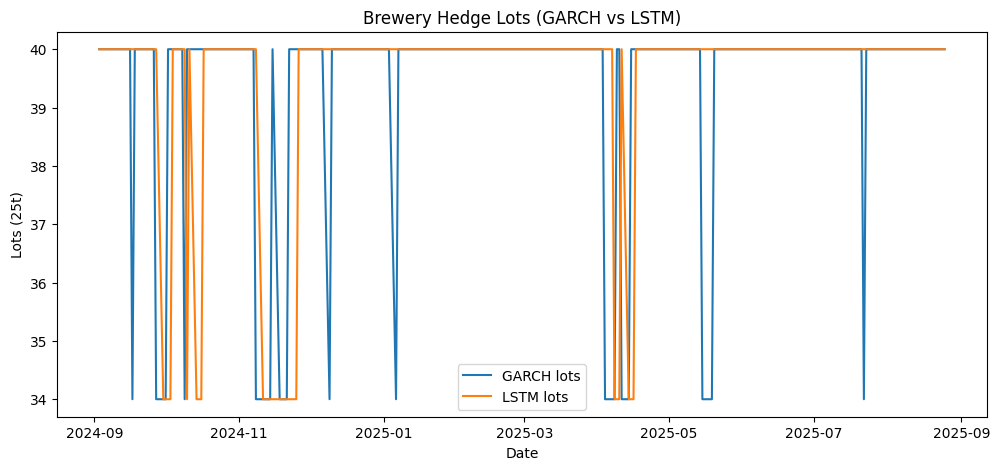

In [ ]:
common_idx2 = hr.index.intersection(garch_var.index).intersection(lstm_var.index)


hr_adj2 = hr.reindex(common_idx2).iloc[:, 0]


gvar2 = garch_var.reindex(common_idx2)
thr2 = gvar2.quantile(0.9)
trim2 = (gvar2 > thr2).map({True: 0.85, False: 1.0})
hedge_lots_garch = ((hr_adj2 * trim2) * expected_tons_next_month / contract_size_tons).round()


lvar2 = lstm_var.reindex(common_idx2)
thrL = lvar2.quantile(0.9)
trimL = (lvar2 > thrL).map({True: 0.85, False: 1.0})
hedge_lots_lstm = ((hr_adj2 * trimL) * expected_tons_next_month / contract_size_tons).round()


hedge_compare = pd.DataFrame({
    'hedge_lots_garch': hedge_lots_garch,
    'hedge_lots_lstm': hedge_lots_lstm
}, index=common_idx2).dropna()

print(hedge_compare.tail(10))


plt.figure(figsize=(12,5))
plt.plot(hedge_compare.index, hedge_compare['hedge_lots_garch'], label='GARCH lots')
plt.plot(hedge_compare.index, hedge_compare['hedge_lots_lstm'], label='LSTM lots')
plt.title("Brewery Hedge Lots (GARCH vs LSTM)")
plt.xlabel("Date")
plt.ylabel("Lots (25t)")
plt.legend()
plt.savefig("aluminum_price2.png", dpi=300, bbox_inches='tight')
plt.show()